# Get Data from Single Velocity
From all of the Al data, get only that from `v = 1.0`. Also, mark the initial transient

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in the Entire Dataset
This includes data from all velocities and all trajectories

In [2]:
data = pd.read_pickle(os.path.join('..', 'training_data.pkl.gz'))
print('Loaded %d entries'%len(data))

Loaded 50069 entries


Add the starting frame

In [3]:
start_frame = pkl.load(open(os.path.join('..', 'al_starting_frame.pkl'), 'rb'))

## Get the `v = 1.0` subset
Nice and easy query

In [4]:
data = data[np.isclose(data['velocity'].apply(np.linalg.norm), 1.0)]
print('Downselected to %d entries'%len(data))

Downselected to 11800 entries


In [5]:
traj_names = set(data['directory'])
print('Number of trajectories:', len(traj_names))
assert len(traj_names) == 2

Number of trajectories: 2


## Mark the Initial Transients
The forces in the first part of the simulation are too high because the system is still reacting to the introduction of the projectile.

In [6]:
data['initial'] = False

In [7]:
traj_names

{'datasets\\256_Al\\Dv1.0', 'datasets\\Al_256_channel'}

### For the Random Trajectory
One of the two trajectories we have is along a random path

In [8]:
random_traj = 'datasets\\256_Al\\Dv1.0'

In [9]:
random_traj

'datasets\\256_Al\\Dv1.0'

In [10]:
random_data = data[data['directory'] == random_traj].copy()

Plot the force as a function of displacement for the beginning part of the trajectory

Text(0,0.5,'Force ($E_H/a_B$)')

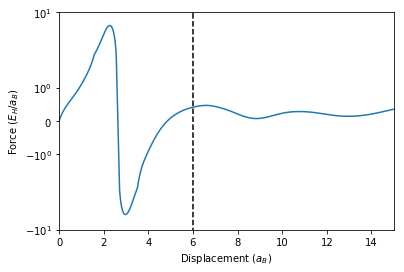

In [11]:
fig, ax = plt.subplots()

ax.plot(random_data['displacement'], random_data['force'])
ax.plot([6,6], [-100,100], 'k--')

ax.set_yscale('symlog')

ax.set_xlim(0, 15)
ax.set_ylim(-10, 10)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H/a_B$)')

*Finding*: The choice of 6 $a_B$ by Schleife *et al* seems reasonable

In [12]:
random_data.loc[random_data.query('displacement < 6').index, 'initial'] = True

## Channel Trajectory
The other trajectory is along a channel in the FCC structure

In [13]:
channel_data = data[data['directory'] == "datasets\\Al_256_channel"].copy()

Text(0,0.5,'Force ($E_H/a_B$)')

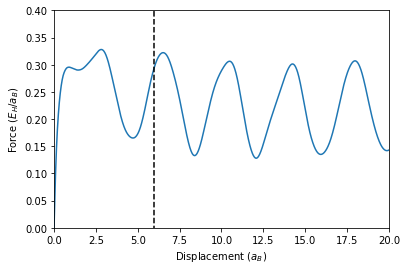

In [14]:
fig, ax = plt.subplots()

ax.plot(channel_data['displacement'], channel_data['force'])
ax.plot([6,6], [-100,100], 'k--')

ax.set_xlim(0, 20)
ax.set_ylim(0, 0.4)

ax.set_xlabel('Displacement ($a_B$)')
ax.set_ylabel('Force ($E_H/a_B$)')

*Finding*: The 6 $a_B$ cutoff also seems like a good choce here as well

In [15]:
channel_data.loc[channel_data.query('displacement < 6').index, 'initial'] = True

Also determine the range to average over, between the 1st and 3rd lattice spacings

In [16]:
lat_spacing = start_frame.cell[0,0] / 4

In [17]:
channel_data['average_range'] = False

In [18]:
channel_data.loc[channel_data.query('displacement >= {}  and displacement <= {}'.format(lat_spacing, 3 * lat_spacing)).index,
                 'average_range'] = True

## Save the Results to Disk
For easy use later

In [19]:
if not os.path.isdir('data'):
    os.mkdir('data')

In [20]:
channel_data.to_pickle(os.path.join('data', 'channel_data.pkl.gz'))

In [21]:
random_data.to_pickle(os.path.join('data', 'random_data.pkl.gz'))